# First problem

## Preparing the environment

We first need to load the documents and libraries we are going to use.

In [1]:
import pandas as pd
import numpy as np
import pyomo
from pyomo.environ import *
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
random.seed(1)
from prettytable import PrettyTable
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
demand = pd.read_csv('demand.csv')
demand_printable = pd.read_csv('demand.csv')
cpsector = pd.read_csv('cpsector.csv', index_col=0)
cpsector_printable = pd.read_csv('cpsector.csv', index_col=0)
cpday = pd.read_csv('cpday.csv', index_col=0)
cpday_printable = pd.read_csv('cpday.csv', index_col=0)
mfsector= pd.read_csv('mfsector.csv', index_col=0)
mfsector_printable= pd.read_csv('mfsector.csv', index_col=0)
mfday= pd.read_csv('mfday.csv', index_col=0)
mfday_printable= pd.read_csv('mfday.csv', index_col=0)

## Formulation of the problem

## Problem definition

We are going to act as a company of self-service cars. We have used the Shared Cars Locations dataset (https://www.kaggle.com/datasets/gidutz/autotel-shared-car-locations/data) from Kaggle, in which we can track car movement in Tel Aviv. This dataset works by providing the data for cars parked in each parking spot in Tel Aviv every 2 minutes, with their *latitude*, *longitude*, *number of cars parked*, *list of ids of the cars parked* and *timestamp*. We have analysed and cleaned this dataset in a separate file, to obtain the **demand** for cars of this company. We have separated Tel Aviv in 5 different sectors, and distributed the parking sports in them. 

The aim for this project is to optimize the company's decisions to offer the most effective service while maximizing the profit. 

We will optimize the **price** for each sector-day combination, measured in euros. This price establishes the cost per minute of a client using any of our cars. Since the demand is expressed in minutes, we can compute easily the facturation. We will not be focusing on the cost of oil for this project. 


## Formal definition

**Sets:**
* $I = \{1,\ldots, 7\}, \text{Days}$
* $J = \{1,\ldots, 5\}, \text{Sectors}$

**Parameters (demand, competence prices and minimum faturation):**
* $d_{ij}$: expected demand in sector $i$ on day $j$
* $cpsector_{i}$: competence price for a car in sector $i$
* $cpday_{j}$: competence price for a car on day $j$
* $mfsector_{i}$: minimum facturation required in sector $i$
* $mfday_{j}$: minimum facturation required on day $j$
* $higher_{ijk}$: whether the demand on day $i$ in sector $j$ is higher than the demand on day $k$ in sector $j$

**Decision variables:**
* $x_{ijk}$: price for any car located in sector $j$ on day $i$

**Objective function:** maximize the revenue 
$$\max_{\bf{x}} \sum_{j}\sum_{i} p_{ij}d_{ij}$$

**Constraints:**

* The mean price across all sectors for a given day does not surpass the price of the competence for that day.
 $$ \frac{\sum_{i}x_{ij}}{5} \leq ccpday_{j}, \quad \forall j \in J $$

* The mean price across all days for a given sector does not surpass the price of the competence for that sector.
$$ \frac{\sum_{j}x_{ij}}{7} \leq ccpsector_{i}, \quad \forall i \in I $$

* The prices must be higher than 15 cents and lower than 50 cents.
$$ 0.15 \leq x_{ij} \leq 0.5 $$

* Each sector has a minimum facturation requirement which has to be met for the company to be sustainable.
$$ \sum_{j}x_{ij}d_{ij} \geq mfsector_{i}, \quad \forall i \in I $$

* Each day has a minimum facturation requirement which has to be met for the company to be sustainable.
$$ \sum_{i}x_{ij}d_{ij} \geq mfday_{j}, \quad \forall j \in J $$

* If a demand on sector A and day c is higher than the demand on sector B and day c, the price on sector A day c has to be higher than the price on sector B on day c.
$$ \text{higher}_{ijk}x_{ij} - x_{kj} \leq 0, \quad \forall k \in I, \quad k \neq i$$

We have the demand table, which represents the demand for each sector-day combination. We will have this in mind to compute the profit for each day and sector.

In [3]:
demand_printable.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_printable.columns = ['Sector 0', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4']
demand_printable.head(len(demand_printable))

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Monday,16093,23317,21618,25635,38308
Tuesday,14033,18040,13958,21594,34491
Wednesday,17672,20545,16902,27223,36276
Thursday,14541,18798,15012,20992,35114
Friday,11250,16811,12637,23229,36748
Saturday,11192,12874,8983,22349,37594
Sunday,26147,28739,23207,33377,48962


We will define a function that helps us fetch the values for each instance. This function works by specifying the value of the sector (0-4) and the day (Monday=0; Tuesday=1 and so on).

In [4]:
def get_demand(sector, day):
    return demand.iloc[day, sector]

In [5]:
# Example
get_demand(0,5)

11192

We also have the prices of the competence for each sector, no matter the day of the week. This will make us be careful about not stablishing abusive prices, because the clients would choose other companies instead.

In [6]:
cpsector.columns = [0,1,2,3,4]
cpsector_printable.head()

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Competence Prices,0.32,0.37,0.33,0.41,0.43


Let's also create the function to fetch the values for this table.

In [7]:
def get_cpsector(sector):
    return cpsector.loc["Competence Prices", sector]

In [8]:
# Example
get_cpsector(2)

0.33

Next, we have the prices of the competence for each day of the week, which acts in the same way as the table we presented right before.

In [9]:
cpday.index = [0,1,2,3,4,5,6]
cpday_printable.head(7)

,Competence Prices
Monday,0.34
Tuesday,0.42
Wednesday,0.41
Thursday,0.46
Friday,0.43
Saturday,0.36
Sunday,0.39


And the function for this table will be as follows.

In [10]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def get_cpday(day):
    return cpday.loc[day, 'Competence Prices']

In [11]:
# Example
get_cpday(0)

0.34

Let's look at the minimum facturation requirements for each sector:

In [12]:
mfsector.columns = [0, 1, 2, 3, 4]
mfsector_printable.head()

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Minimum Facturation,31000,32000,29000,33000,28000


With its correspondent function:

In [13]:
def get_mfsector(sector):
    return mfsector.loc["Minimum Facturation", sector]

In [14]:
# Example
get_mfsector(4)

28000

And there are also minimum facturation requirements for each day:

In [15]:
mfday.index = [0, 1, 2, 3, 4, 5, 6]
mfday_printable.head(len(mfday_printable))

,Minimum Facturation
Monday,25000
Tuesday,24000
Wednesday,26000
Thursday,23000
Friday,22000
Saturday,21000
Sunday,27000


Which we can also access through a function:

In [16]:
def get_mfday(day):
    return mfday.loc[day, 'Minimum Facturation']

In [17]:
# Example
get_mfday(6)

27000

We will know display all the information we have in a big table, featuring the sectors, days, totals, competence prices and minimum facturation.

In [18]:
whole_table = demand_printable.copy()
whole_table.loc['Total'] = whole_table.sum()
whole_table['Total'] = whole_table.sum(axis=1)

In [19]:
whole_table = pd.concat([whole_table, cpday_printable, mfday_printable], axis=1, sort=False)
whole_table = pd.concat([whole_table, cpsector_printable, mfsector_printable], axis=0, sort=False)
whole_table = whole_table.fillna('')

In [20]:
whole_table

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4,Total,Competence Prices,Minimum Facturation
Monday,16093.00,23317.00,21618.00,25635.00,38308.00,124971.0,0.34,25000.0
Tuesday,14033.00,18040.00,13958.00,21594.00,34491.00,102116.0,0.42,24000.0
Wednesday,17672.00,20545.00,16902.00,27223.00,36276.00,118618.0,0.41,26000.0
Thursday,14541.00,18798.00,15012.00,20992.00,35114.00,104457.0,0.46,23000.0
Friday,11250.00,16811.00,12637.00,23229.00,36748.00,100675.0,0.43,22000.0
Saturday,11192.00,12874.00,8983.00,22349.00,37594.00,92992.0,0.36,21000.0
Sunday,26147.00,28739.00,23207.00,33377.00,48962.00,160432.0,0.39,27000.0
Total,110928.00,139124.00,112317.00,174399.00,267493.00,804261.0,,
Competence Prices,0.32,0.37,0.33,0.41,0.43,,,
Minimum Facturation,31000.00,32000.00,29000.00,33000.00,28000.00,,,


We will also compute a table with higher-lower data between sector-day combinations. It is a 5 dimensional array (one dimension for each sector), in which the instances can only take values 1 or 3.34, based on if the demand(i,j) is higher or lower than the demand(k,j), for the same day.

In [21]:
higher = np.zeros((5, 7, 5))

for i in range(5):
    for j in range(7):
        for k in range(5):
            if get_demand(i, j) > get_demand(k,j):
                 higher[i, j, k] = 1
            else:
                higher[i, j, k] = 3.34

In [22]:
# Example
print("Demand on sector 3, Friday= ", get_demand(3,4), "\nDemand on sector 2, Friday= ", get_demand(2, 4), 
      "\nValue on table higher for first instance= ", higher[3, 4, 2], 
      "\nValue on table higher for second instance= ", higher[2, 4, 3], 
     "\n\n Since the first value is higher than the second, the first value in higher is 1 and the second is 3,34")

Demand on sector 3, Friday=  23229 
Demand on sector 2, Friday=  12637 
Value on table higher for first instance=  1.0 
Value on table higher for second instance=  3.34 

 Since the first value is higher than the second, the first value in higher is 1 and the second is 3,34


## Implementation of the model

Initialize the model

In [23]:
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

### Sets

* $I = \{1,\ldots, 7\}, \text{Days}$
* $J = \{1,\ldots, 5\}, \text{Sectors}$

In [24]:
sectors = range(5)  # Sectors 0 to 4
days = range(7) # Days 0 to 6

### Decision variables

$x_{ijk}$: price for any car located in sector $j$ on day $i$

In [25]:
model.x = Var(sectors, days, domain=NonNegativeReals)

### Objective function

$$\max_{\bf{x}} \sum_{j}\sum_{i} p_{ij}d_{ij}$$

In [26]:
model.obj = Objective(
    expr=sum(get_demand(sector, day) * model.x[sector, day] for sector in sectors for day in days),
    sense=maximize)

### Constraints

The mean price across all days for a given sector does not surpass the price of the competence for that sector.

$$ \frac{\sum_{j}x_{ij}}{7} \leq ccpsector_{i}, \quad \forall i \in I $$

In [27]:
model.pricesector0 = Constraint(expr= (sum(model.x[0, day] for day in days)/7) <= get_cpsector(0))
model.pricesector1 = Constraint(expr= (sum(model.x[1, day] for day in days)/7) <= get_cpsector(1))
model.pricesector2 = Constraint(expr= (sum(model.x[2, day] for day in days)/7) <= get_cpsector(2))
model.pricesector3 = Constraint(expr= (sum(model.x[3, day] for day in days)/7) <= get_cpsector(3))
model.pricesector4 = Constraint(expr= (sum(model.x[4, day] for day in days)/7) <= get_cpsector(4))

The mean price across all sectors for a given day does not surpass the price of the competence for that day.

 $$ \frac{\sum_{i}x_{ij}}{5} \leq ccpday_{j}, \quad \forall j \in J $$

In [28]:
model.pricemonday = Constraint(expr= (sum(model.x[sector, 0] for sector in sectors)/5) <= get_cpday(0))
model.pricetuesday = Constraint(expr= (sum(model.x[sector, 1] for sector in sectors)/5) <= get_cpday(1))
model.pricewednesday = Constraint(expr= (sum(model.x[sector, 2] for sector in sectors)/5) <= get_cpday(2))  
model.pricethursday = Constraint(expr= (sum(model.x[sector, 3] for sector in sectors)/5) <= get_cpday(3))                        
model.pricefriday = Constraint(expr= (sum(model.x[sector, 4] for sector in sectors)/5) <= get_cpday(4))
model.pricesaturday = Constraint(expr= (sum(model.x[sector, 5] for sector in sectors)/5) <= get_cpday(5))                         
model.pricesunday = Constraint(expr= (sum(model.x[sector, 6] for sector in sectors)/5) <= get_cpday(6))

Each sector has a minimum facturation requirement which has to be met for the company to be sustainable.

$$ \sum_{j}x_{ij}d_{ij} \geq mfsector_{i}, \quad \forall i \in I $$

In [29]:
model.minimumfacturationsector0 = Constraint(expr=sum(model.x[0, day] * get_demand(0, day) for day in days) >= get_mfsector(0))
model.minimumfacturationsector1 = Constraint(expr=sum(model.x[1, day] * get_demand(1, day) for day in days) >= get_mfsector(1))
model.minimumfacturationsector2 = Constraint(expr=sum(model.x[2, day] * get_demand(2, day) for day in days) >= get_mfsector(2))
model.minimumfacturationsector3 = Constraint(expr=sum(model.x[3, day] * get_demand(3, day) for day in days) >= get_mfsector(3))
model.minimumfacturationsector4 = Constraint(expr=sum(model.x[4, day] * get_demand(4, day) for day in days) >= get_mfsector(4))

Each day has a minimum facturation requirement which has to be met for the company to be sustainable.

$$ \sum_{i}x_{ij}d_{ij} \geq mfday_{j}, \quad \forall j \in J $$

In [30]:
model.minimumfacturationmonday = Constraint(expr= sum(model.x[sector, 0]*get_demand(sector, 0) for sector in sectors) >= get_mfday(0))
model.minimumfacturationtuesday = Constraint(expr= sum(model.x[sector, 1]*get_demand(sector, 1) for sector in sectors) >= get_mfday(1))
model.minimumfacturationwednesday = Constraint(expr= sum(model.x[sector, 2]*get_demand(sector, 2) for sector in sectors) >= get_mfday(2))  
model.minimumfacturationthursday = Constraint(expr= sum(model.x[sector, 3]*get_demand(sector, 3) for sector in sectors) >= get_mfday(3))                        
model.minimumfacturationfriday = Constraint(expr= sum(model.x[sector, 4]*get_demand(sector, 4) for sector in sectors) >= get_mfday(4))
model.minimumfacturationsaturday = Constraint(expr= sum(model.x[sector, 5]*get_demand(sector, 5) for sector in sectors) >= get_mfday(5))                         
model.minimumfacturationsunday = Constraint(expr= sum(model.x[sector, 6]*get_demand(sector, 6) for sector in sectors) >= get_mfday(6))

The prices must be higher than 15 cents and lower than 50 cents.

$$ 0.15 \leq x_{ij} \leq 0.5 $$

In [31]:
for i in range(5):
    for j in range(7):
        constraint_name = f'higherthan15_{i}_{j}'
        model.add_component(constraint_name, Constraint(expr=model.x[i, j] >= 0.15))

In [32]:
for i in range(5):
    for j in range(7):
        constraint_name = f'lowerthan50_{i}_{j}'
        model.add_component(constraint_name, Constraint(expr=model.x[i, j] <= 0.5))

If a demand on sector A and day c is higher than the demand on sector B and day c, the price on sector A day c has to be higher than the price on sector B on day c.

$$ \text{higher}_{ijk}x_{ij} - x_{kj} \leq 0, \quad \forall k \in I, \quad k \neq i$$

In [33]:
def higherDemand(model, i, j, r):
    constraint_value = higher[i, j, r] * model.x[i, j] - model.x[r, j]
    return constraint_value >= -1e-6

In [34]:
model.higherdemandhigherprice= Constraint(sectors, days, sectors, rule=higherDemand)

### Initialize the solver and solve the model

In [35]:
solver = SolverFactory('gurobi')
solver.solve(model)

{'Problem': [{'Name': 'x1', 'Lower bound': 315831.48600950005, 'Upper bound': 315831.48600950005, 'Number of objectives': 1, 'Number of constraints': 269, 'Number of variables': 35, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 35, 'Number of nonzeros': 525, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.0010001659393310547', 'Error rc': 0, 'Time': 0.32898879051208496}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Interpreting the solution

Here we have the solution obtained by the model:

In [36]:
for sector in sectors:
    for day in days:
        dayprint = day_mapping.get(day, None)
        print(f"Price of cars on {dayprint} in Sector {sector}: {model.x[sector, day].value}")

# Print the total revenue
print(f"Total revenue: {model.obj()}")

Price of cars on Monday in Sector 0: 0.15
Price of cars on Tuesday in Sector 0: 0.4200005999999999
Price of cars on Wednesday in Sector 0: 0.4100004
Price of cars on Thursday in Sector 0: 0.4600006
Price of cars on Friday in Sector 0: 0.20399680000000067
Price of cars on Saturday in Sector 0: 0.15
Price of cars on Sunday in Sector 0: 0.44600159999999994
Price of cars on Monday in Sector 1: 0.3875005
Price of cars on Tuesday in Sector 1: 0.4199995999999999
Price of cars on Wednesday in Sector 1: 0.40999939999999996
Price of cars on Thursday in Sector 1: 0.4599996
Price of cars on Friday in Sector 1: 0.31650030000000023
Price of cars on Saturday in Sector 1: 0.15
Price of cars on Sunday in Sector 1: 0.44600059999999997
Price of cars on Monday in Sector 2: 0.3875005
Price of cars on Tuesday in Sector 2: 0.4200006
Price of cars on Wednesday in Sector 2: 0.4100004
Price of cars on Thursday in Sector 2: 0.46000059999999987
Price of cars on Friday in Sector 2: 0.3165013000000002
Price of cars

Which we will display with a more clear version in a table

In [37]:
results = {
    "Monday": [model.x[sector, 0].value for sector in range(5)],
    "Tuesday": [model.x[sector, 1].value for sector in range(5)],
    "Wednesday": [model.x[sector, 2].value for sector in range(5)],
    "Thursday": [model.x[sector, 3].value for sector in range(5)],
    "Friday": [model.x[sector, 4].value for sector in range(5)],
    "Saturday": [model.x[sector, 5].value for sector in range(5)],
    "Sunday": [model.x[sector, 6].value for sector in range(5)],
}

results = pd.DataFrame(results)
results= pd.DataFrame.transpose(results)
results_printable = results.copy()
results.index = [0, 1, 2, 3, 4, 5, 6]
results_printable.columns = ['Sector 0', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4']
results_printable = results_printable.round(2)
results_printable

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Monday,0.15,0.39,0.39,0.39,0.39
Tuesday,0.42,0.42,0.42,0.42,0.42
Wednesday,0.41,0.41,0.41,0.41,0.41
Thursday,0.46,0.46,0.46,0.46,0.46
Friday,0.20,0.32,0.32,0.50,0.50
Saturday,0.15,0.15,0.15,0.25,0.39
Sunday,0.45,0.45,0.17,0.45,0.45


We will print also the facturation for each sector

In [38]:
print("Facturation for each sector: \n", (results_printable * demand_printable).sum(), "\n")
print("Facturation for each day: \n", (results_printable * demand_printable).sum(axis=1))

Facturation for each sector: 
 Sector 0     37937.14
Sector 1     53984.13
Sector 2     37465.20
Sector 3     72106.28
Sector 4    115520.50
dtype: float64 

Facturation for each day: 
 Monday       44876.37
Tuesday      42888.72
Wednesday    48633.38
Thursday     48050.22
Friday       41661.86
Saturday     25206.26
Sunday       65696.44
dtype: float64


### Plots

Let's see the plots for the demand and price for the different sectors across the different days of the week. In this plot we can see that the highest demand belongs to sector 4, then sector 3, then sector 1 and finally sector 0 and 2 are interchangeably getting last place. When looking at the second plot (in which we used less opacity to better see the results, we see that this order is somewhat still present, which we stablished in one of our constraints. The only destacable thing is that the prices for sector 1 and 2 follow a very similar pattern.

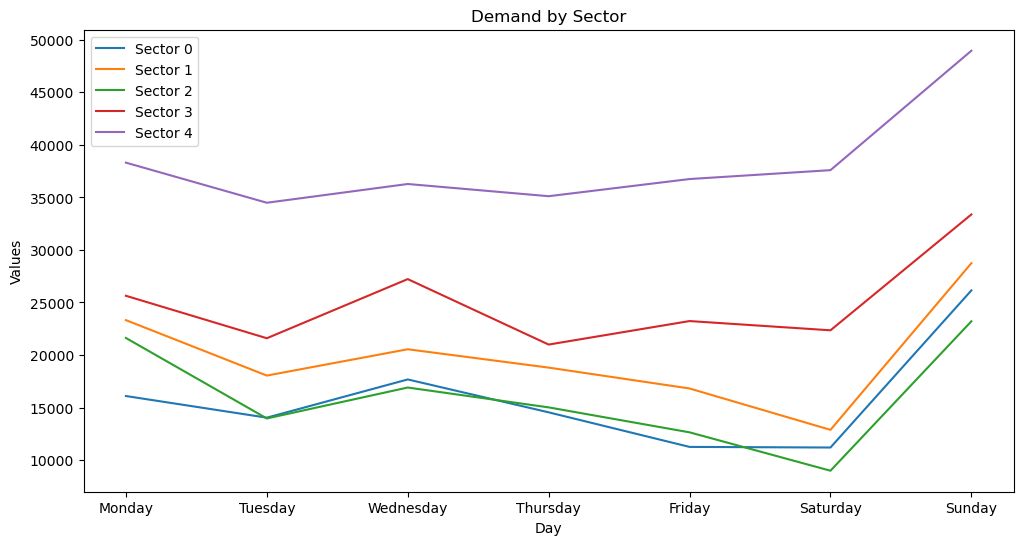

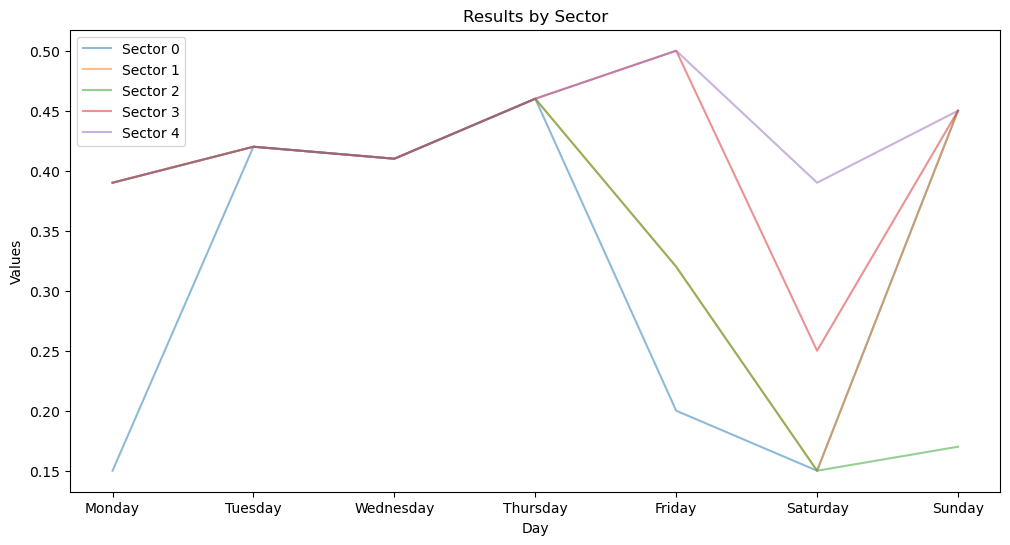

In [39]:
results_days, results_values = results_printable.index, results_printable.values.astype(float)
demand_days, demand_values = demand_printable.index, demand_printable.values.astype(int)

plt.figure(figsize=(12, 6))

for sector, values in enumerate(demand_values.T):
    plt.plot(demand_days, values, label=f'Sector {sector}', alpha=1)

plt.title('Demand by Sector')
plt.xlabel('Day')
plt.ylabel('Values')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

for sector, values in enumerate(results_values.T):
    plt.plot(results_days, values, label=f'Sector {sector}', alpha=0.5)

plt.title('Results by Sector')
plt.xlabel('Day')
plt.ylabel('Values')
plt.legend()
plt.show()

In the following plot we just printed both graphs on top of each other to show the relationship between the prices and the demands together.

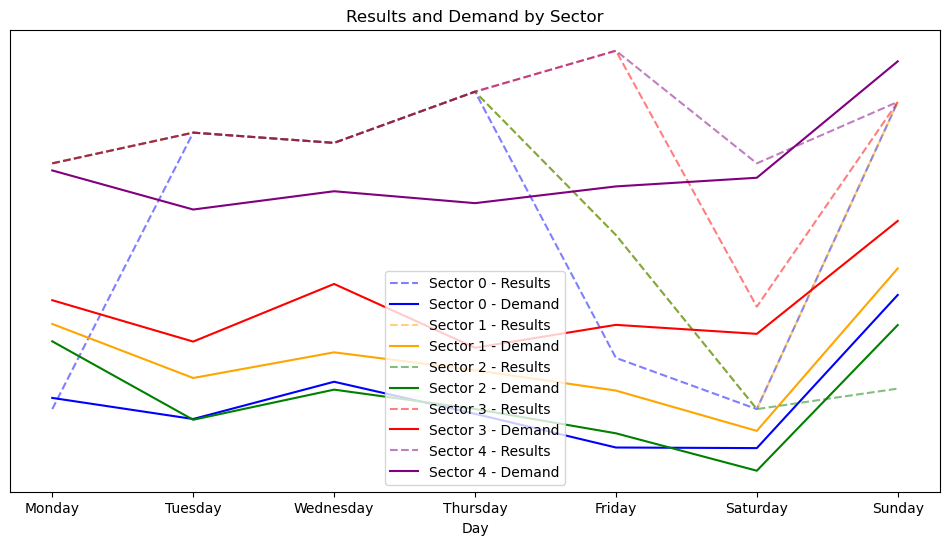

In [40]:
results_days, results_values = results_printable.index, results_printable.values.astype(float)
demand_days, demand_values = demand_printable.index, demand_printable.values.astype(int)
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plotting results and demand
plt.figure(figsize=(12, 6))

for sector, (result_values, demand_values) in enumerate(zip(results_values.T, demand_values.T)):
    # Plot results
    plt.plot(results_days, result_values, label=f'Sector {sector} - Results', color=colors[sector], alpha=0.5, linestyle='--')

    # Plot demand (scaled for better visibility)
    plt.plot(demand_days, demand_values / 100000, label=f'Sector {sector} - Demand', color=colors[sector], alpha=1)

plt.title('Results and Demand by Sector')
plt.xlabel('Day')
plt.yticks([])
plt.legend()
plt.show()

And finally from the following plot we see the different relationships between price and demand for the different sectors. Here what we can study as interesting is that the prices somewhat resemble the demand distributions, although they do not perfectly follow them because of the rest of the constraints. In the last plot, we have displayed the mean for demand and price for all sectors, which gives an insight about how the model tried to follow the demand distribution to stablish the prices. Of course, in the other plots, we see that this was not possible in every instance because of all the other constraints, which also imposed other criteria to meet.

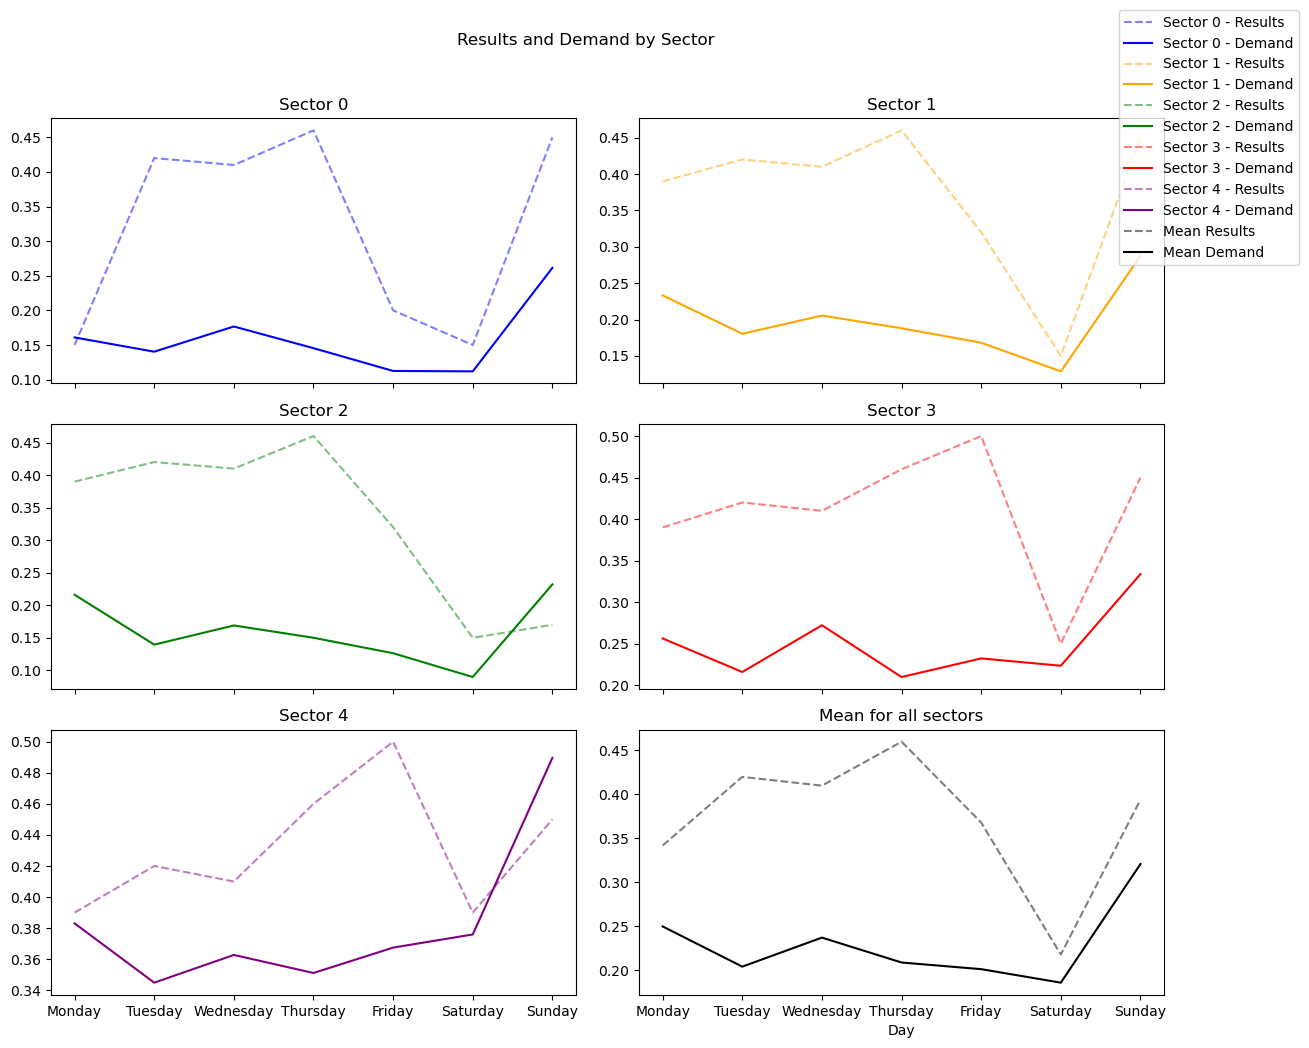

In [41]:
results_days, results_values = results_printable.index, results_printable.values.astype(float)
demand_days, demand_values = demand_printable.index, demand_printable.values.astype(int)
colors = ['blue', 'orange', 'green', 'red', 'purple']
num_sectors = len(sectors)

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for sector, ax in enumerate(axes):
    if sector < num_sectors: 
        ax.plot(results_days, results_values[:, sector], label=f'Sector {sector} - Results', color=colors[sector], linestyle='--', alpha=0.5)
        ax.plot(demand_days, demand_values[:, sector] / 100002, label=f'Sector {sector} - Demand', color=colors[sector], alpha=1)
        ax.set_title(f'Sector {sector}')
    else:
        ax.plot(results_days, np.mean(results_values, axis=1), label='Mean Results', color='black', linestyle='--', alpha=0.5)
        ax.plot(demand_days, np.mean(demand_values, axis=1) / 100002, label='Mean Demand', color='black', alpha=1)
        ax.set_title('Mean for all sectors')

fig.suptitle('Results and Demand by Sector', y=1.02)
plt.xlabel('Day')
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

## Sensitivities in our problem

We will now see the sensitivities of out constraints. We will separate them in groups.

In [42]:
dual_values = {}

for constraint in model.component_data_objects(Constraint, active=True):
    dual_values[constraint] = model.dual[constraint]

#### Price per sector constraints

In [43]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if i < 5:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint pricesector0: 78750.0
Dual value for constraint pricesector1: 127394.40000000002
Dual value for constraint pricesector2: 78741.59999999998
Dual value for constraint pricesector3: 156443.0
Dual value for constraint pricesector4: 263158.0


We see from this all sectors were affected by this constraint, that means, a change in 1 unit in the competence price for each sector would make a difference in the result of the model.

#### Price per day contraints

In [44]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 4 < i < 12:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint pricemonday: 24358.749999999996
Dual value for constraint pricetuesday: 1475.0
Dual value for constraint pricewednesday: 17977.000000000004
Dual value for constraint pricethursday: 3816.0000000000014
Dual value for constraint pricefriday: 0.0
Dual value for constraint pricesaturday: 0.0
Dual value for constraint pricesunday: 59791.0


This constraint does not affect the prices on Friday nor Saturday. However, the other days are affected, ones more highly than others.

#### Minimum facturation per sector contraints

In [45]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 11 < i < 17:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint minimumfacturationsector0: 0.0
Dual value for constraint minimumfacturationsector1: 0.0
Dual value for constraint minimumfacturationsector2: 0.0
Dual value for constraint minimumfacturationsector3: 0.0
Dual value for constraint minimumfacturationsector4: 0.0


We can clearly see that the minimum facturation constraint is not important to get the solutions for our model, given it does not have any influence.

#### Minimum facturation per day contraints

In [46]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 16 < i < 24:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint minimumfacturationmonday: 0.0
Dual value for constraint minimumfacturationtuesday: 0.0
Dual value for constraint minimumfacturationwednesday: 0.0
Dual value for constraint minimumfacturationthursday: 0.0
Dual value for constraint minimumfacturationfriday: 0.0
Dual value for constraint minimumfacturationsaturday: 0.0
Dual value for constraint minimumfacturationsunday: 0.0


The same happens with the price for each day. A possible explanation is that our values for minimum facturation are too low for our model, or that the price for the competence was too rigid and had too much influence on it.

#### Higher than constraints

In [47]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 23 < i < 59:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint higherthan15_0_0: -28.75
Dual value for constraint higherthan15_0_1: 0.0
Dual value for constraint higherthan15_0_2: 0.0
Dual value for constraint higherthan15_0_3: 0.0
Dual value for constraint higherthan15_0_4: 0.0
Dual value for constraint higherthan15_0_5: -58.0
Dual value for constraint higherthan15_0_6: 0.0
Dual value for constraint higherthan15_1_0: 0.0
Dual value for constraint higherthan15_1_1: 0.0
Dual value for constraint higherthan15_1_2: 0.0
Dual value for constraint higherthan15_1_3: 0.0
Dual value for constraint higherthan15_1_4: 0.0
Dual value for constraint higherthan15_1_5: -5325.200000000001
Dual value for constraint higherthan15_1_6: 0.0
Dual value for constraint higherthan15_2_0: 0.0
Dual value for constraint higherthan15_2_1: 0.0
Dual value for constraint higherthan15_2_2: 0.0
Dual value for constraint higherthan15_2_3: 0.0
Dual value for constraint higherthan15_2_4: 0.0
Dual value for constraint higherthan15_2_5: -2265.7999999999956
Dual

We see here that the sensitivities have had an impact in the model. This could be explained by the model giving prices to satisfy the other constraints without necessarily following the demand. Since we imposed that the demand distribution had to be somewhat correspondent to the price results, we see that it has had an impact in the solution. However, a lot of these constraint sensitivities are different from zero. The effect of these sentivities can be seen in the table, given that a lot of our price values are more than 0.15. For those that are exactly 0.15, we can see their values here.

#### Lower than 50 cents constraints

In [48]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 58 < i < 94:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint lowerthan50_0_0: 0.0
Dual value for constraint lowerthan50_0_1: 0.0
Dual value for constraint lowerthan50_0_2: 0.0
Dual value for constraint lowerthan50_0_3: 0.0
Dual value for constraint lowerthan50_0_4: 0.0
Dual value for constraint lowerthan50_0_5: 0.0
Dual value for constraint lowerthan50_0_6: 0.0
Dual value for constraint lowerthan50_1_0: 0.0
Dual value for constraint lowerthan50_1_1: 0.0
Dual value for constraint lowerthan50_1_2: 0.0
Dual value for constraint lowerthan50_1_3: 0.0
Dual value for constraint lowerthan50_1_4: 0.0
Dual value for constraint lowerthan50_1_5: 0.0
Dual value for constraint lowerthan50_1_6: 0.0
Dual value for constraint lowerthan50_2_0: 0.0
Dual value for constraint lowerthan50_2_1: 0.0
Dual value for constraint lowerthan50_2_2: 0.0
Dual value for constraint lowerthan50_2_3: 0.0
Dual value for constraint lowerthan50_2_4: 0.0
Dual value for constraint lowerthan50_2_5: 0.0
Dual value for constraint lowerthan50_2_6: 0.0
Dual value fo

This shows that 1 value would be higher than 50 cents if we had not imposed this constraint. If we look again at the results, there is just one price that is exactly 50 cents, and that is the price that are different from zero in the sensitivities. The other price that is 0.50 in the tables is shown as 4.99 in the results.

#### Higher demand contraints

In [49]:
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if 93 < i:
        print(f"Dual value for constraint {constraint}: {dual_value}")

Dual value for constraint higherdemandhigherprice[0,0,0]: 0.0
Dual value for constraint higherdemandhigherprice[0,0,1]: 0.0
Dual value for constraint higherdemandhigherprice[0,0,2]: 0.0
Dual value for constraint higherdemandhigherprice[0,0,3]: 0.0
Dual value for constraint higherdemandhigherprice[0,0,4]: 0.0
Dual value for constraint higherdemandhigherprice[0,1,0]: 0.0
Dual value for constraint higherdemandhigherprice[0,1,1]: 0.0
Dual value for constraint higherdemandhigherprice[0,1,2]: 0.0
Dual value for constraint higherdemandhigherprice[0,1,3]: 0.0
Dual value for constraint higherdemandhigherprice[0,1,4]: 0.0
Dual value for constraint higherdemandhigherprice[0,2,0]: 0.0
Dual value for constraint higherdemandhigherprice[0,2,1]: 0.0
Dual value for constraint higherdemandhigherprice[0,2,2]: 0.0
Dual value for constraint higherdemandhigherprice[0,2,3]: 0.0
Dual value for constraint higherdemandhigherprice[0,2,4]: 0.0
Dual value for constraint higherdemandhigherprice[0,3,0]: 0.0
Dual val

We see that these constraints also have had an effect on the model, which means that some prices were decided based on some demand factors. Although many of these values are zero, we can argue that this was an important constraint because of the number of non-zero values. We also had a lot of different constraints alltogether, which maybe made this constraint be met in any case for some of this combinations, without having to apply the constraint necessarily.

### Conclusions about the sensitivities

In [50]:
counter=0
for i, (constraint, dual_value) in enumerate(dual_values.items()):
    if dual_value!=0:
        counter+=1
counter

35

We have found 35 constraints that have had an effect on our model. Since we iterated through a lot of combinations, we got an initial amount of 269 constraints (displayed when we solved the model), but not all of them were important when stablishing the prices of our sector-day car combinations. This is because some of the constraints were very tight to meet and had a greater impact than the looser constraints, that were fulfilled without any extra computations. 

# Second problem (Binary part)

## Formulation of the problem

## Problem definition

To ensure a high-quality service for the clients, each car from a fleet of 100 cars must undergo a scheduled maintenance service once a week. This maintenance check verifies that each car functions correctly and identifies any potential damages. As in the previous part, the pricing for the car-sharing service varies on a daily basis and across different sectors.

We encounter two constraints in this optimization process:

* Workshop Capacity: The workshop dedicated to car maintenance has a finite daily capacity, limiting the number of cars that can undergo maintenance each day. Specifically, the maximum capacity is set at 20 cars per day.

* Sector Demand: Beyond the cars undergoing maintenance, the remaining vehicles in the fleet need to be allocated strategically. This allocation must be done in a manner that aligns with the demand for each sector on a given day.

Our goal is to obtain an efficient maintenance schedule and car allocation that optimally balances workshop capacity and sector-specific demands while maximizing the obtained revenue.


## Formal definition

**Sets:**
* $I = \{1,\ldots, 7\}, \text{Days}$
* $J = \{1,\ldots, 5\}, \text{Sectors}$
* $K = \{1,\ldots, 100\}, \text{Cars}$

**Parameters:**
* $d_{ij}$: demand on a ceratin day $i$ in a certain sector $j$
* $c_{ij}$: price per minute for a car $k$ on day $i$ in sector $j$, even though the objective function is not informative in this case, it serves the purpose of maximizing the whole revenue

**Decision variables:**
* $x_{ijk}$: whether car $k$ is located in sector $j$ on day $i$
* $y_{ik}$: whether car $k$ undergoes maintenance on day $i$

**Objective function:** maximize the revenue 
$$\max_{\bf{x}} \sum_{i} \sum_{j} \sum_{k} c_{ij}x_{ijk}$$

**Constraints:**

* A maximum of 20 cars can undergo maintenance on one day in the workshop
$$\sum_{k}y_{ik}<=20, \forall i\in I$$

* A demand for each day and sector has to be accomplished
$$\sum_k x_{ijk} >= Demand_{ij}, \forall j\in J, \forall i \in I$$

* A car has to undergo maintenance just one time every week
$$\sum_i y_{ik} = 1, \forall k\in K$$

* A car cannot be allocated if it undergoes maintenance that same day
$$x_{ijk} <= 1-y_{ik}, \forall i\in I, \forall j\in J, \forall k\in K$$

* A car cannot be allocated in another sector if it is already allocated that same day
$$\sum_{j}x_{ijk} <= 1, \forall i\in I, \forall k \in K$$

## Data

It can be helpful to see what are the data we are working with

### Demand

The demands are estimated from the original dataset based on the first 100 cars' indices, that is why we can see that proportionally this demands can vary from the ones used in the previous part

In [51]:
demand_binary_part = pd.read_csv('demand_binary_part.csv', index_col=0)
demand_binary_part_printable = demand_binary_part
demand_binary_part_printable.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_binary_part_printable.columns = ['Sector 0', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4']

demand_binary_part

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Monday,22,11,8,12,12
Tuesday,23,8,7,15,14
Wednesday,23,9,8,15,14
Thursday,26,10,8,18,15
Friday,25,10,6,15,17
Saturday,27,4,6,8,18
Sunday,24,8,9,13,15


### Prices (cost)

As we have said, we will used the prices optimized in the previous part in this part as the cost in our objective function. Although the objective value does not inform us of how much revenue we obtain, using the prices as the cost ensures that we are maximizing the revenue.

In [52]:
results_printable

,Sector 0,Sector 1,Sector 2,Sector 3,Sector 4
Monday,0.15,0.39,0.39,0.39,0.39
Tuesday,0.42,0.42,0.42,0.42,0.42
Wednesday,0.41,0.41,0.41,0.41,0.41
Thursday,0.46,0.46,0.46,0.46,0.46
Friday,0.20,0.32,0.32,0.50,0.50
Saturday,0.15,0.15,0.15,0.25,0.39
Sunday,0.45,0.45,0.17,0.45,0.45


## Sets, Parameters and Decision variables

Define our sets $I$ (days), $J$ (sectors) and $K$ (cars) and we will assign them a descriptive name for convenience

In [53]:
days = range(0, 7) # Number of days
sectors = range(0, 5) # Number of sectors
cars = range(0, 100) # Number of cars

model = ConcreteModel()

model.days = Set(initialize=days, doc='Days')
model.sectors = Set(initialize=sectors, doc='Sectors')
model.cars = Set(initialize=cars, doc='Cars')

Now we will assign **prices** for in sector on each day which are those optimized in the previous part, they will be our costs: $c_{ij}$

In [54]:
prices = {(i, j): np.asarray(results)[i,j] for i in days for j in sectors}
model.prices = Param(model.days, model.sectors, initialize=prices, doc='Prices')

Then we will assing a **demand** that must be accomplished in each sector on each day, this demand is estimated from the original carsharing dataset: $Demand_{ij}$

In [55]:
demand = {(i,j): np.asarray(demand_binary_part)[i,j] for i in days for j in sectors}
model.demand = Param(model.days, model.sectors, initialize=demand, doc='Demand')

Now we will define our **location** variable $x_{ijk}$ and **maintenance** variable $y_{ik}$ which are both binary variables

In [56]:
model.x = Var(model.days, model.sectors, model.cars, within=Binary)  # Location variable x_ijk
model.y = Var(model.days, model.cars, within=Binary) # Maintenance variable y_ik

## Objective function
Define our objetive function: $$\max_{\bf{x}} \sum_{i} \sum_{j} \sum_{k} c_{ij}x_{ijk}$$

In [57]:
model.obj = Objective(expr=sum(model.prices[i, j] * model.x[i, j, k] for i in model.days for j in model.sectors for k in model.cars), sense=maximize)

## Constraints 
---
Define the constraint that limits the maximum number of car on maintenance per day to 20: $$\sum_{k}y_{ik}<=20, \forall i\in I$$

In [58]:
model.max_cars_per_day = ConstraintList()
for i in model.days:
    model.max_cars_per_day.add(sum(model.y[i, k] for k in model.cars) <= 20)

---
Define the constraint that sets a minimum demand for each sector on each day: $$\sum_k x_{ijk} >= Demand_{ij}, \forall j\in J, \forall i \in I$$

In [59]:
model.demand_constraint = ConstraintList()
for i in days:
    for j in sectors:
        model.demand_constraint.add(sum(model.x[i, j, k] for k in cars) >= model.demand[i,j])

---
Define the constraint that specifies that each car has to undergo maintenance once a week:
$$\sum_i y_{ik} = 1, \forall k\in K$$

In [60]:
model.maintenance_constraint = ConstraintList()
for k in model.cars:
    model.maintenance_constraint.add(sum(model.y[i, k] for i in model.days) == 1 )

---
Define the constraint that specifies that a car cannot be allocated if it undergoes maintenance that day:
$$x_{ijk} <= 1-y_{ik}, \forall i\in I, \forall j\in J, \forall k\in K$$

In [61]:
model.logic_constraint_maintenance = ConstraintList()
for i in model.days:
    for j in model.sectors:
        for k in model.cars:
            model.logic_constraint_maintenance.add(model.x[i,j,k]<=1-model.y[i,k])

---
Define the constraint that specifies if a car is allocated in a sector in cannot be allocated in another sector that same day:
$$\sum_{j}x_{ijk} <= 1, \forall i\in I, \forall k \in K$$

In [62]:
model.logic_constraint_location = ConstraintList()
for i in model.days:
        for k in model.cars:
            model.logic_constraint_location.add(sum(model.x[i,j,k] for j in model.sectors) <= 1)

## Solve the model

Now we solve the model using the *gurobi* solver

In [63]:
# Insert your code here
Solver = SolverFactory('gurobi')
results = Solver.solve(model)

## Conclusions

Finally we will plot the results and extract conclusions.

In [64]:
result_data = []
for i in days:
    for j in sectors:
        for k in cars:
            result_data.append({
                'Day': i,
                'Sector': j,
                'Car': k,
                'Location': value(model.x[i, j, k]),
                'Maintenance': value(model.y[i, k])
            })
    
    
# Create a DataFrame
results_df = pd.DataFrame(result_data)


In [65]:
print(results_df)

      Day  Sector  Car  Location  Maintenance
0       0       0    0      -0.0         -0.0
1       0       0    1      -0.0         -0.0
2       0       0    2      -0.0          1.0
3       0       0    3      -0.0          0.0
4       0       0    4      -0.0          0.0
...   ...     ...  ...       ...          ...
3495    6       4   95       1.0         -0.0
3496    6       4   96       1.0         -0.0
3497    6       4   97       1.0          0.0
3498    6       4   98       1.0         -0.0
3499    6       4   99       0.0         -0.0

[3500 rows x 5 columns]


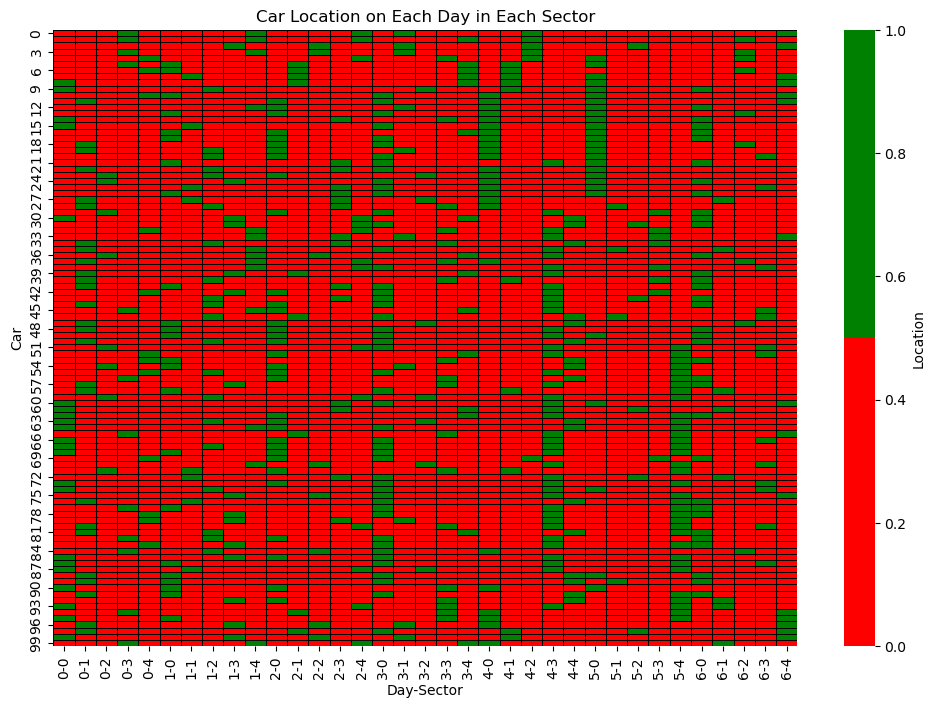

In [66]:
pivot_location = results_df.pivot_table(values='Location', index='Car', columns=['Day', 'Sector'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_location, cmap=['red', 'green'], cbar_kws={'label': 'Location'}, linewidths=0.5, linecolor='black')
plt.title('Car Location on Each Day in Each Sector')
plt.show()

In this graph we can see how the allocation of cars is distributed optimally meeting each demand and respecting the constraints

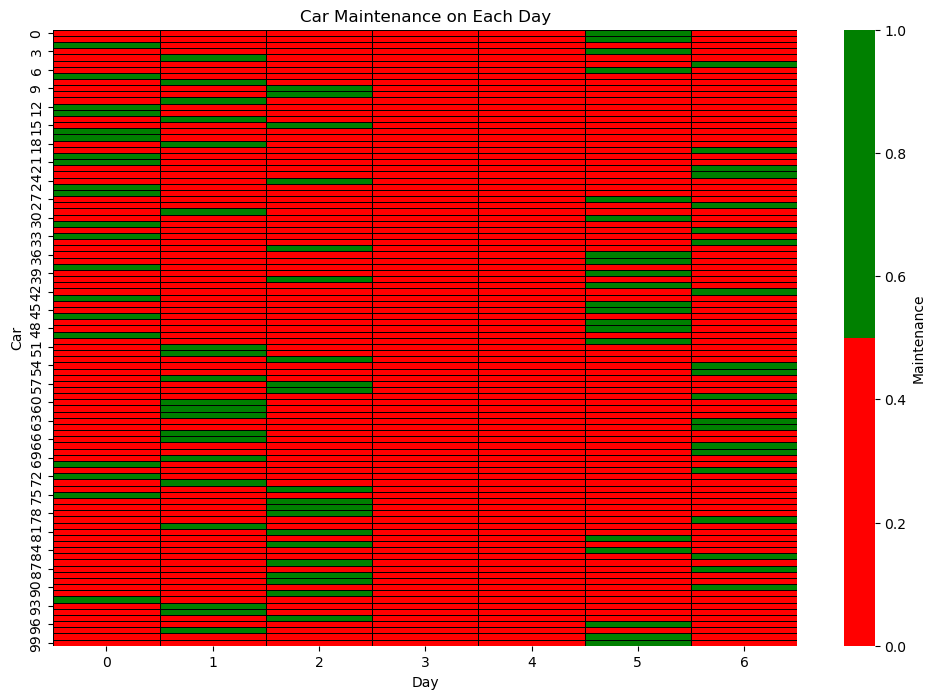

In [67]:
pivot_maintenance = results_df.pivot_table(values='Maintenance', index='Car', columns='Day')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_maintenance, cmap=['red', 'green'], cbar_kws={'label': 'Maintenance'}, linewidths=0.5, linecolor='black')
plt.title('Car Maintenance on Each Day')
plt.show()

Now we can see how each car undergoies maintenance in such a way the cut in revenue is minimized, again respecting the constraint of maximum 20 cars per day

Overall, visually, we can see that the optimization problem is solved correctly by checking:

* That each car undergoes maintenance at least once a week

* The demand of each day in each sector is satisfied

* Comparing the demand and price data to the obtained results we can see that the cars seem to be allocated properly

Finally we will also plot some lineplots in order to see the relations between the parameters and the results

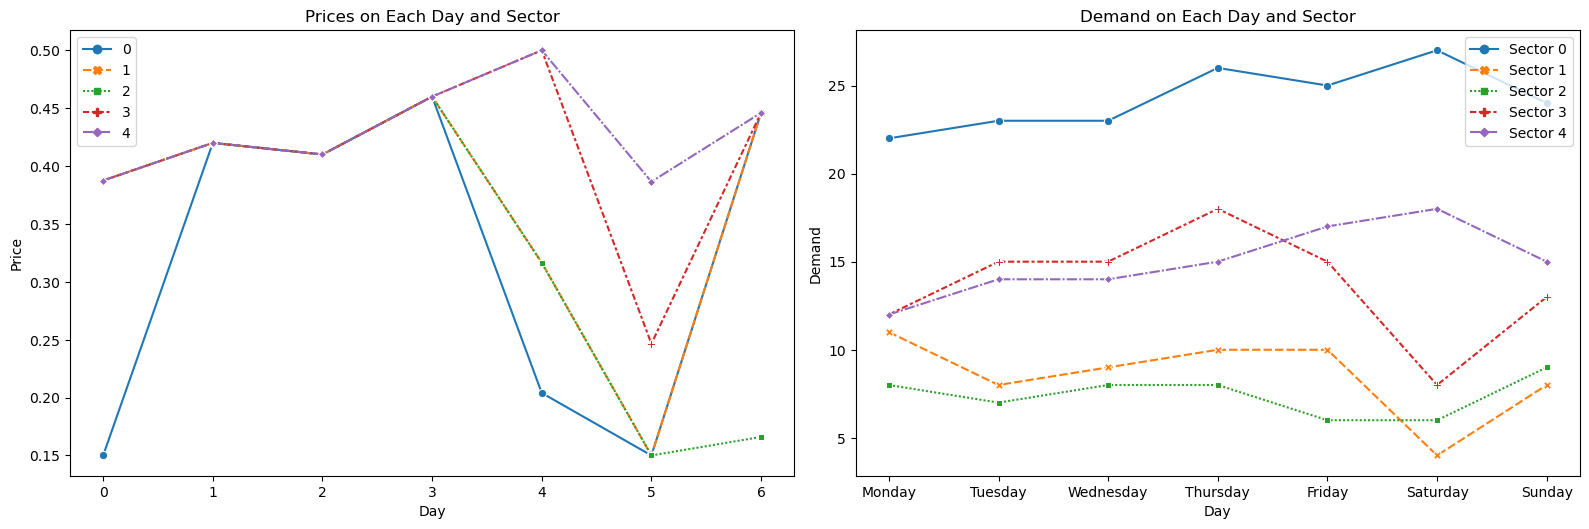

In [68]:
plt.figure(figsize=(16, 10))

# Plot Prices
plt.subplot(2, 2, 1)
sns.lineplot(data=[[prices[i, j] for i in days] for j in sectors], markers=True)
plt.title('Prices on Each Day and Sector')
plt.xlabel('Day')
plt.ylabel('Price')

# Plot Demand
plt.subplot(2, 2, 2)
sns.lineplot(data=demand_binary_part, markers=True)
plt.title('Demand on Each Day and Sector')
plt.xlabel('Day')
plt.ylabel('Demand')

plt.tight_layout()
plt.show()

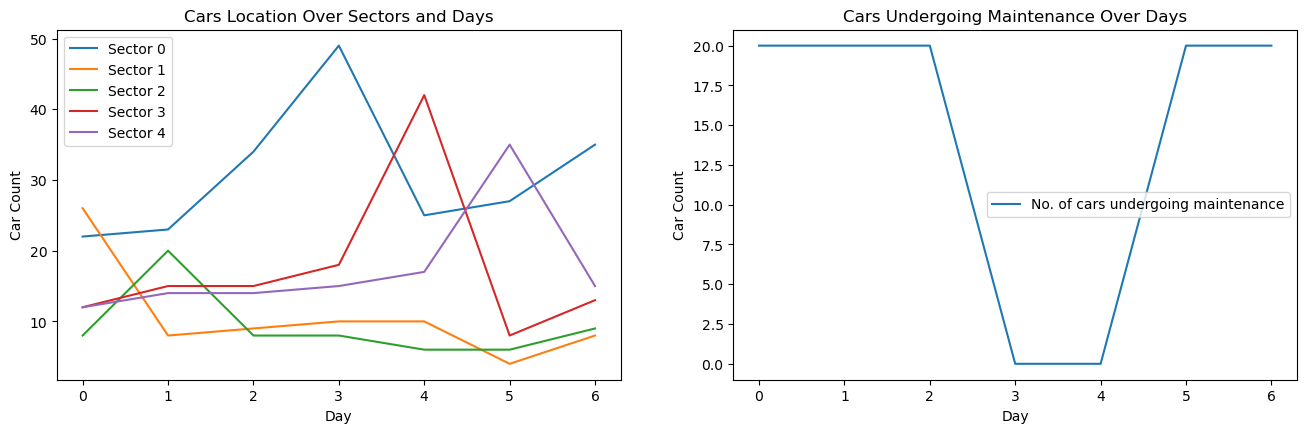

In [69]:
pivot_location = results_df.pivot_table(values='Location', index='Car', columns=['Sector', 'Day'])
# Line plot for the count of cars located
plt.figure(figsize=(16, 10))

plt.subplot(2,2,1)
for j in sectors:
    plt.plot(days, pivot_location[j].sum(), label=f'Sector {j}')
plt.xlabel('Day')
plt.ylabel('Car Count')
plt.title('Cars Location Over Sectors and Days')
plt.legend()

# Line plot for the count of cars under maintenance
plt.subplot(2,2,2)
plt.plot(days, pivot_maintenance.sum(), label=f'No. of cars undergoing maintenance')
plt.xlabel('Day')
plt.ylabel('Car Count')
plt.title('Cars Undergoing Maintenance Over Days')
plt.legend()
plt.show()


From these graphs we can clearly see how the allocation of cars meet the demand and how de maintenance of the cars is distributed in such a way that we get a nice balance between price and demand in such a way that we maximize the revenue and comparing the price and demand graphs we can see how they are combined in the cars allocation graph.
